In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/ST/stargan

Mounted at /content/drive
/content/drive/MyDrive/ST/stargan


In [2]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import os

seed = 2710
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
class MultiBranchSiameseNet(nn.Module):
    def __init__(self, num_classes=5, num_timesteps=128):
        super(MultiBranchSiameseNet, self).__init__()
        # Shared layers
        self.conv1 = nn.Conv1d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.fc_shared = nn.Linear(num_timesteps * 8, 100)

        # Class-specific branches
        self.fc_class_branches = nn.Linear(100, 50 * num_classes)

    def forward_once(self, x, class_id):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc_shared(x))

        # Process class-specific branch
        class_branches = self.fc_class_branches(x).view(x.size(0), -1, 50)
        class_output = class_branches[torch.arange(class_branches.size(0)), class_id]
        return class_output

    def forward(self, input1, input2, class_id1, class_id2):
        output1 = self.forward_once(input1, class_id1)
        output2 = self.forward_once(input2, class_id2)
        return output1, output2

def contrastive_loss(output1, output2, label, margin=1.0):
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
    loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive, euclidean_distance

In [4]:
def split_data(x, y, k, test_size=0.2, random_state=seed):
    x_train, x_test, y_train, y_test, k_train, k_test = train_test_split(x, y, k,
                                                                         test_size=test_size,
                                                                         random_state=random_state,
                                                                         stratify=k,
                                                                         shuffle=True)
    return x_train, x_test, y_train, y_test, k_train, k_test

In [5]:
def setup_training(x_train, y_train, k_train, x_test, y_test, k_test, batch_size=64):
    # Convert numpy arrays to torch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    k_train_tensor = torch.tensor(k_train, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    k_test_tensor = torch.tensor(k_test, dtype=torch.long)

    # Create datasets and loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor, k_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor, k_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

In [6]:
def evaluate_model(model, test_loader, loss_fn, device='cpu', margin=1.0):
    model.eval()
    total_loss = 0
    same_domain_distance = 0
    diff_domain_distance = 0
    same_domain_count = 0
    diff_domain_count = 0

    with torch.no_grad():
        for x_batch, y_batch, k_batch in test_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            batch_size = x_batch.size(0)

            # Compute all pairwise outputs
            output1 = model.forward_once(x_batch.unsqueeze(1).expand(-1, batch_size, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(1).expand(-1, batch_size).reshape(-1))
            output2 = model.forward_once(x_batch.unsqueeze(0).expand(batch_size, -1, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(0).expand(batch_size, -1).reshape(-1))

            output1 = output1.view(batch_size, batch_size, -1)
            output2 = output2.view(batch_size, batch_size, -1)

            # Compute pairwise distances
            euclidean_distances = F.pairwise_distance(output1, output2, keepdim=True).view(batch_size, batch_size)

            # Compute pairwise labels
            labels = (k_batch.unsqueeze(1) != k_batch.unsqueeze(0)).float()

            # Compute loss
            loss = (1 - labels) * torch.pow(euclidean_distances, 2) + labels * torch.pow(torch.clamp(margin - euclidean_distances, min=0.0), 2)
            total_loss += loss.mean().item()

            # Compute distances for same and different domains
            same_domain_distance += euclidean_distances[labels == 0].sum().item()
            diff_domain_distance += euclidean_distances[labels == 1].sum().item()
            same_domain_count += (labels == 0).sum().item()
            diff_domain_count += (labels == 1).sum().item()

    total_loss /= len(test_loader)
    avg_same_domain_distance = same_domain_distance / same_domain_count if same_domain_count > 0 else 0
    avg_diff_domain_distance = diff_domain_distance / diff_domain_count if diff_domain_count > 0 else 0

    return total_loss, avg_same_domain_distance, avg_diff_domain_distance

In [7]:
def train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=300, name='siamese_net', margin=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_train = []
    loss_test = []
    avg_same_domain_distance_test = []
    avg_diff_domain_distance_test = []
    best_loss = np.inf

    # Set up linear learning rate decay
    lambda_lr = lambda epoch: 1 - epoch / epochs
    scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, k_batch in train_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            batch_size = x_batch.size(0)

            # Compute all pairwise outputs
            output1 = model.forward_once(x_batch.unsqueeze(1).expand(-1, batch_size, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(1).expand(-1, batch_size).reshape(-1))
            output2 = model.forward_once(x_batch.unsqueeze(0).expand(batch_size, -1, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(0).expand(batch_size, -1).reshape(-1))

            output1 = output1.view(batch_size, batch_size, -1)
            output2 = output2.view(batch_size, batch_size, -1)

            # Compute pairwise distances
            euclidean_distances = F.pairwise_distance(output1, output2, keepdim=True).view(batch_size, batch_size)

            # Compute pairwise labels
            labels = (k_batch.unsqueeze(1) != k_batch.unsqueeze(0)).float()

            # Compute loss
            loss = (1 - labels) * torch.pow(euclidean_distances, 2) + labels * torch.pow(torch.clamp(margin - euclidean_distances, min=0.0), 2)
            total_loss += loss.mean().item()

            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

        total_loss /= len(train_loader)
        loss_train.append(total_loss)

        # Update learning rate
        scheduler.step()

        test_loss, avg_same_domain_distance, avg_diff_domain_distance = evaluate_model(model, test_loader, loss_fn, device=device)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict().copy()
        loss_test.append(test_loss)
        avg_same_domain_distance_test.append(avg_same_domain_distance)
        avg_diff_domain_distance_test.append(avg_diff_domain_distance)

        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch + 1}/{epochs} - Train loss: {total_loss:.4f} - Test loss: {test_loss:.4f} - "
              f"Avg same domain distance: {avg_same_domain_distance:.4f} - Avg diff domain distance: {avg_diff_domain_distance:.4f} - LR: {current_lr:.6f}")

    # Save best model
    os.makedirs('pretrained_nets', exist_ok=True)
    if best_model is not None:
        print(f"Saving best model at epoch {np.argmin(loss_test) + 1} and test loss {best_loss:.4f}")
        torch.save(best_model, f"pretrained_nets/{name}.ckpt")
    else:
        print("No best model found, saving current model")
        torch.save(model.state_dict(), f"pretrained_nets/{name}.ckpt")

    return loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test

(7817, 3, 128) (7817,) (7817,)
(6253, 3, 128) (1564, 3, 128) (6253,) (1564,) (6253,) (1564,)
Epoch 1/100 - Train loss: 0.1362 - Test loss: 0.1403 - Avg same domain distance: 0.5835 - Avg diff domain distance: 0.6981 - LR: 0.000099
Epoch 2/100 - Train loss: 0.1080 - Test loss: 0.1236 - Avg same domain distance: 0.5893 - Avg diff domain distance: 0.7352 - LR: 0.000098
Epoch 3/100 - Train loss: 0.1025 - Test loss: 0.1095 - Avg same domain distance: 0.5803 - Avg diff domain distance: 0.7784 - LR: 0.000097
Epoch 4/100 - Train loss: 0.0970 - Test loss: 0.0963 - Avg same domain distance: 0.5719 - Avg diff domain distance: 0.8293 - LR: 0.000096
Epoch 5/100 - Train loss: 0.0908 - Test loss: 0.0851 - Avg same domain distance: 0.5494 - Avg diff domain distance: 0.8656 - LR: 0.000095
Epoch 6/100 - Train loss: 0.0842 - Test loss: 0.0765 - Avg same domain distance: 0.5461 - Avg diff domain distance: 0.9172 - LR: 0.000094
Epoch 7/100 - Train loss: 0.0790 - Test loss: 0.0704 - Avg same domain distance

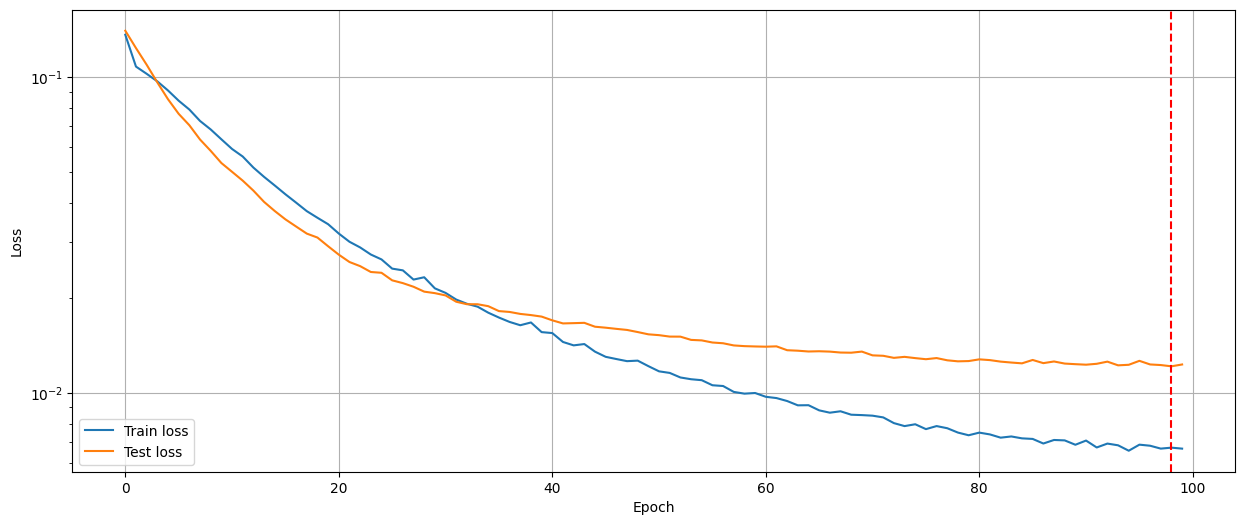

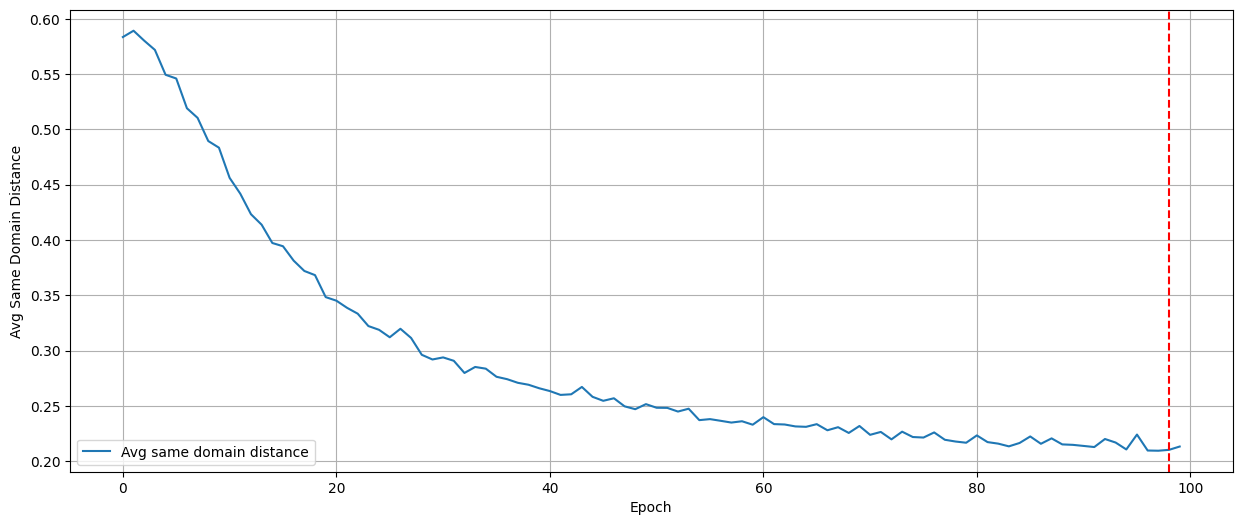

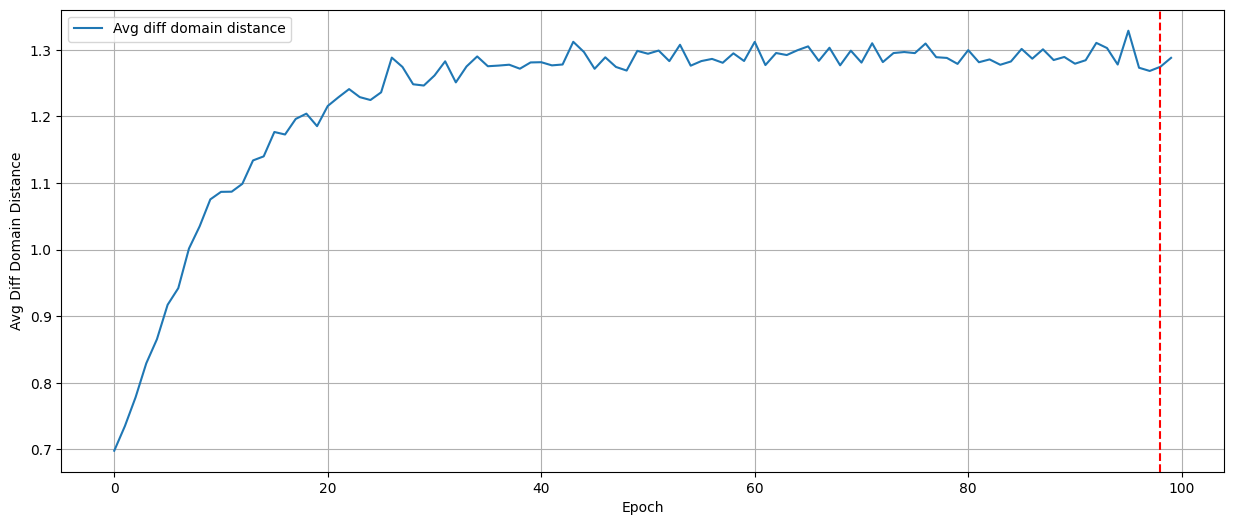

In [8]:
# Train Siamese network on Df (RealWorld)

with open('data/realworld_128_3ch_4cl.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

x = x[k < 10]
y = y[k < 10]
k = k[k < 10]
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchSiameseNet(num_classes=4, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = contrastive_loss

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=100, name='siamese_net_realworld_tr')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Avg same domain distance: {avg_same_domain_distance_test[best_epoch]:.4f} - Avg diff domain distance: {avg_diff_domain_distance_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the average same domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_same_domain_distance_test, label='Avg same domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Same Domain Distance')
plt.legend()
plt.grid()
plt.show()

# Plot the average different domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_diff_domain_distance_test, label='Avg diff domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Diff Domain Distance')
plt.legend()
plt.grid()
plt.show()

(3866, 3, 128) (3866,) (3866,)
(3092, 3, 128) (774, 3, 128) (3092,) (774,) (3092,) (774,)
Epoch 1/100 - Train loss: 0.2579 - Test loss: 0.1963 - Avg same domain distance: 0.5773 - Avg diff domain distance: 0.6424 - LR: 0.000099
Epoch 2/100 - Train loss: 0.1792 - Test loss: 0.1942 - Avg same domain distance: 0.5518 - Avg diff domain distance: 0.6300 - LR: 0.000098
Epoch 3/100 - Train loss: 0.1735 - Test loss: 0.1863 - Avg same domain distance: 0.5450 - Avg diff domain distance: 0.6436 - LR: 0.000097
Epoch 4/100 - Train loss: 0.1683 - Test loss: 0.1707 - Avg same domain distance: 0.5517 - Avg diff domain distance: 0.6836 - LR: 0.000096
Epoch 5/100 - Train loss: 0.1614 - Test loss: 0.1613 - Avg same domain distance: 0.5370 - Avg diff domain distance: 0.7015 - LR: 0.000095
Epoch 6/100 - Train loss: 0.1517 - Test loss: 0.1399 - Avg same domain distance: 0.5480 - Avg diff domain distance: 0.7753 - LR: 0.000094
Epoch 7/100 - Train loss: 0.1420 - Test loss: 0.1328 - Avg same domain distance: 0

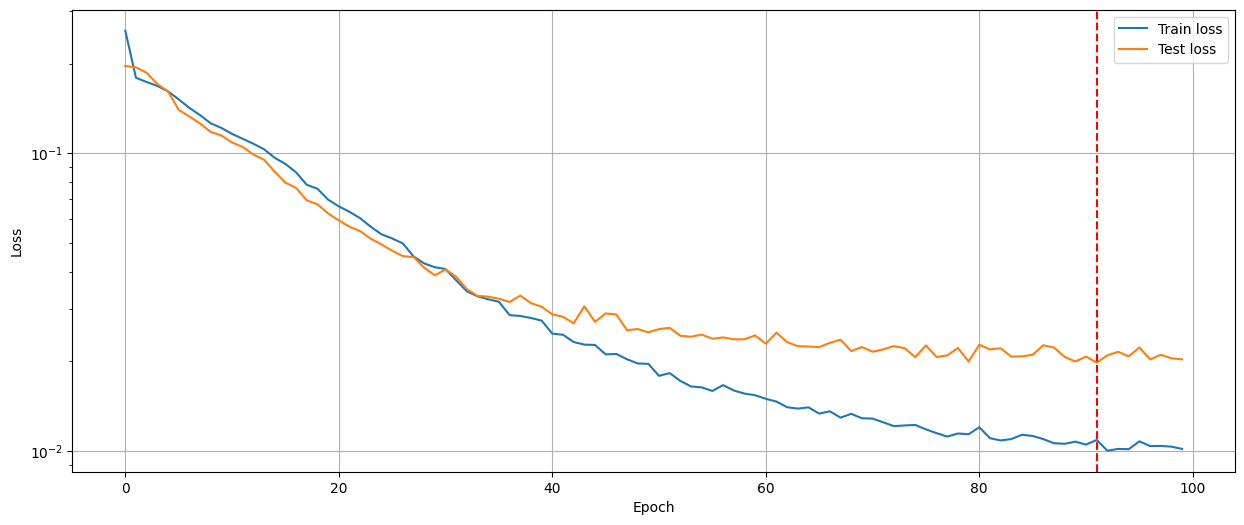

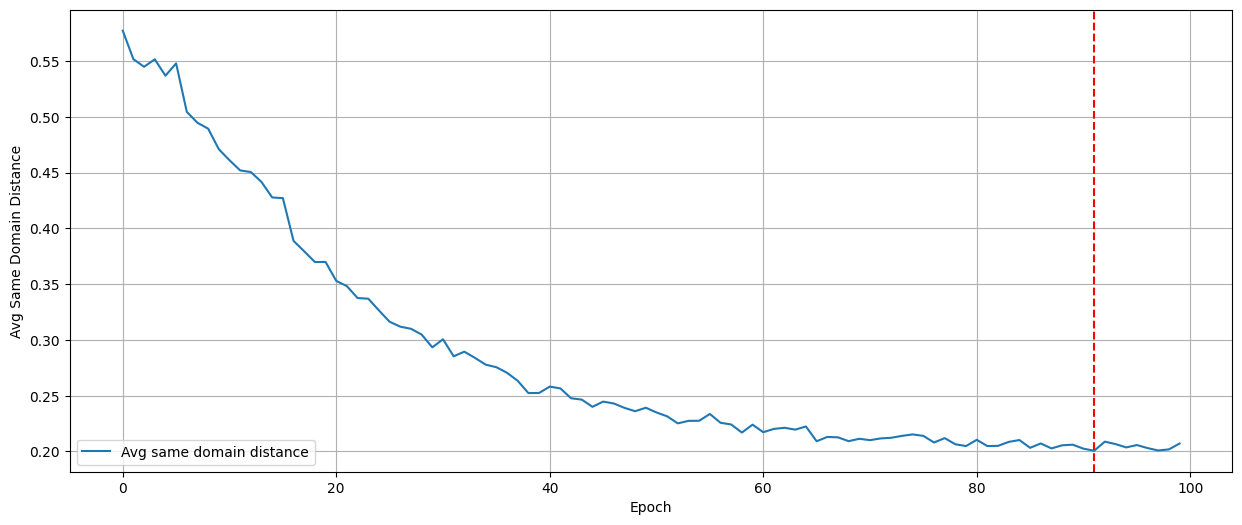

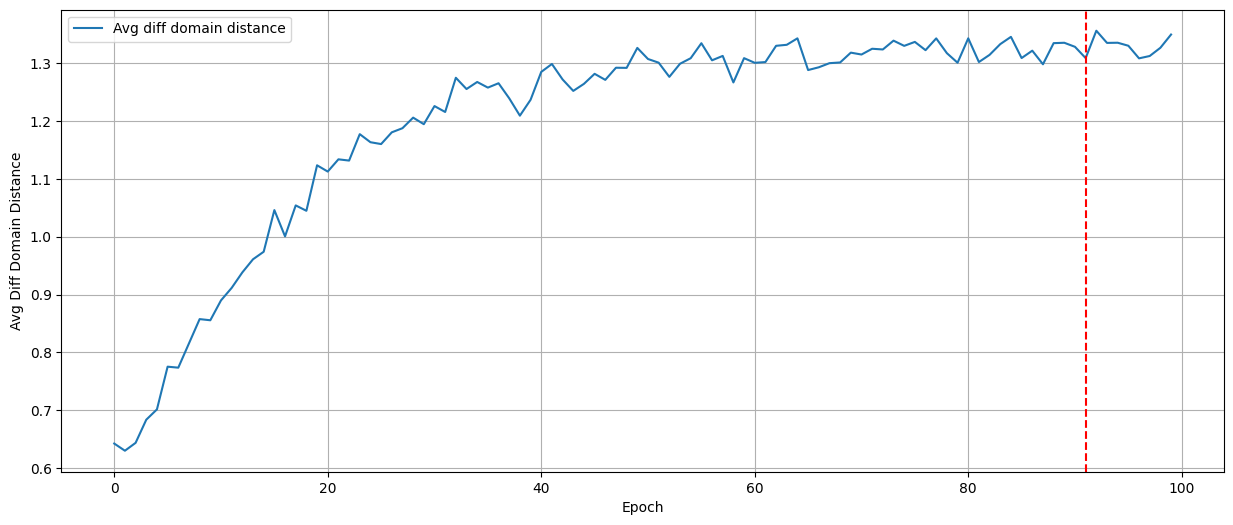

In [9]:
# Train domain classifier on Dp (RealWorld)

with open('data/realworld_128_3ch_4cl.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

with open('data/realworld_128_3ch_4cl_fs.pkl', 'rb') as f:
    fs = pickle.load(f)

x = x[fs == 0]
y = y[fs == 0]
k = k[fs == 0]
x = x[k >= 10]
y = y[k >= 10]
k = k[k >= 10] - 10
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchSiameseNet(num_classes=4, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = contrastive_loss

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=100, name='siamese_net_realworld_te')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Avg same domain distance: {avg_same_domain_distance_test[best_epoch]:.4f} - Avg diff domain distance: {avg_diff_domain_distance_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the average same domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_same_domain_distance_test, label='Avg same domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Same Domain Distance')
plt.legend()
plt.grid()
plt.show()

# Plot the average different domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_diff_domain_distance_test, label='Avg diff domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Diff Domain Distance')
plt.legend()
plt.grid()
plt.show()

(9522, 3, 256) (9522,) (9522,)
(7617, 3, 256) (1905, 3, 256) (7617,) (1905,) (7617,) (1905,)
Epoch 1/100 - Train loss: 0.2438 - Test loss: 0.2319 - Avg same domain distance: 0.5379 - Avg diff domain distance: 0.5739 - LR: 0.000099
Epoch 2/100 - Train loss: 0.2050 - Test loss: 0.2378 - Avg same domain distance: 0.5125 - Avg diff domain distance: 0.5468 - LR: 0.000098
Epoch 3/100 - Train loss: 0.2031 - Test loss: 0.2412 - Avg same domain distance: 0.5024 - Avg diff domain distance: 0.5362 - LR: 0.000097
Epoch 4/100 - Train loss: 0.2052 - Test loss: 0.2426 - Avg same domain distance: 0.4986 - Avg diff domain distance: 0.5325 - LR: 0.000096
Epoch 5/100 - Train loss: 0.2042 - Test loss: 0.2344 - Avg same domain distance: 0.5198 - Avg diff domain distance: 0.5552 - LR: 0.000095
Epoch 6/100 - Train loss: 0.2024 - Test loss: 0.2320 - Avg same domain distance: 0.5248 - Avg diff domain distance: 0.5611 - LR: 0.000094
Epoch 7/100 - Train loss: 0.2019 - Test loss: 0.2379 - Avg same domain distance

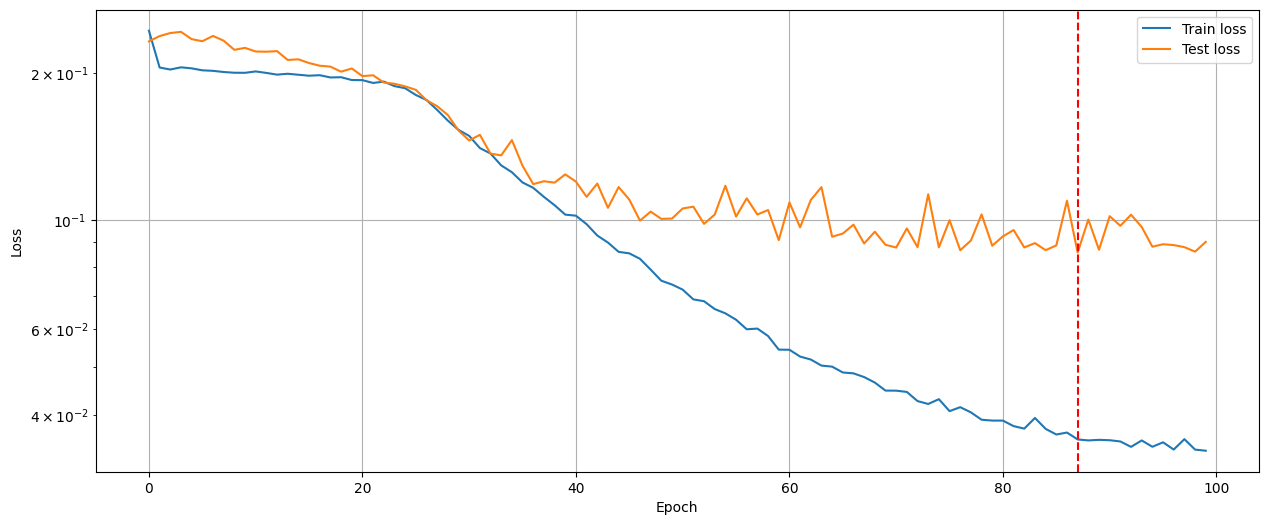

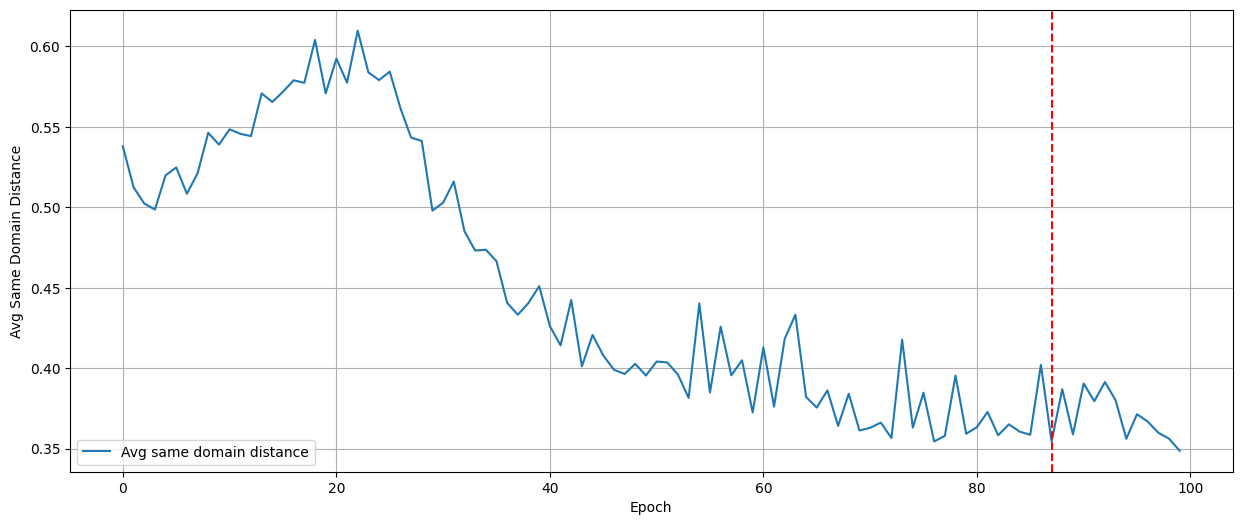

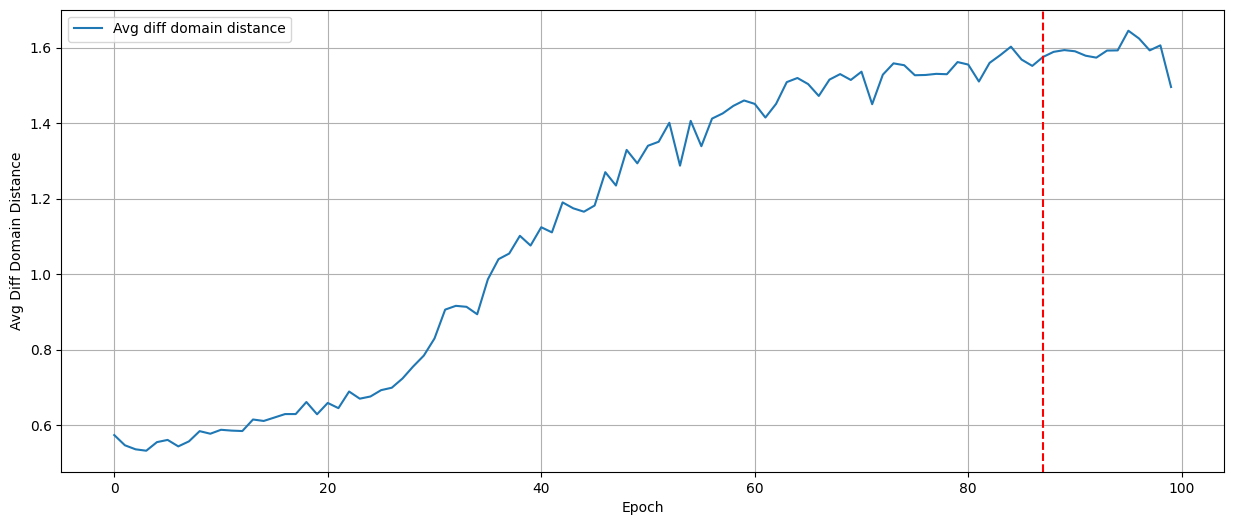

In [10]:
# Train domain classifier on Df (CWRU)

with open('data/cwru_256_3ch_5cl.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

x = x[k < 4]
y = y[k < 4]
k = k[k < 4]
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchSiameseNet(num_classes=5, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = contrastive_loss

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=100, name='siamese_net_cwru_tr')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Avg same domain distance: {avg_same_domain_distance_test[best_epoch]:.4f} - Avg diff domain distance: {avg_diff_domain_distance_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the average same domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_same_domain_distance_test, label='Avg same domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Same Domain Distance')
plt.legend()
plt.grid()
plt.show()

# Plot the average different domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_diff_domain_distance_test, label='Avg diff domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Diff Domain Distance')
plt.legend()
plt.grid()
plt.show()

(9426, 3, 256) (9426,) (9426,)
(7540, 3, 256) (1886, 3, 256) (7540,) (1886,) (7540,) (1886,)
Epoch 1/100 - Train loss: 0.2550 - Test loss: 0.2412 - Avg same domain distance: 0.5319 - Avg diff domain distance: 0.5645 - LR: 0.000099
Epoch 2/100 - Train loss: 0.2050 - Test loss: 0.2374 - Avg same domain distance: 0.5201 - Avg diff domain distance: 0.5537 - LR: 0.000098
Epoch 3/100 - Train loss: 0.2024 - Test loss: 0.2430 - Avg same domain distance: 0.5022 - Avg diff domain distance: 0.5352 - LR: 0.000097
Epoch 4/100 - Train loss: 0.2005 - Test loss: 0.2372 - Avg same domain distance: 0.5164 - Avg diff domain distance: 0.5506 - LR: 0.000096
Epoch 5/100 - Train loss: 0.1989 - Test loss: 0.2330 - Avg same domain distance: 0.5244 - Avg diff domain distance: 0.5601 - LR: 0.000095
Epoch 6/100 - Train loss: 0.1981 - Test loss: 0.2281 - Avg same domain distance: 0.5306 - Avg diff domain distance: 0.5696 - LR: 0.000094
Epoch 7/100 - Train loss: 0.1957 - Test loss: 0.2222 - Avg same domain distance

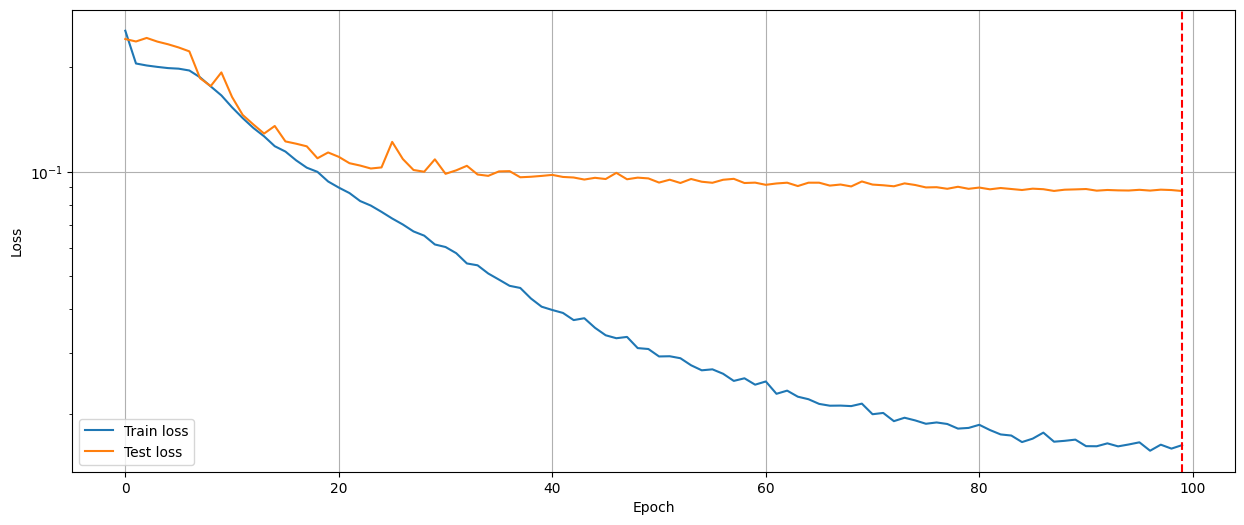

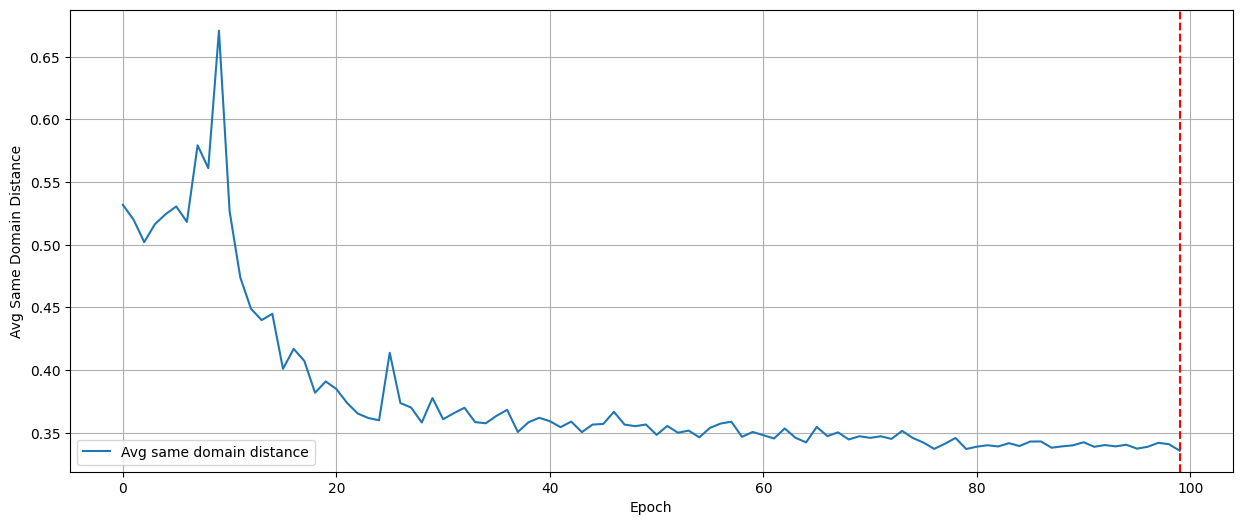

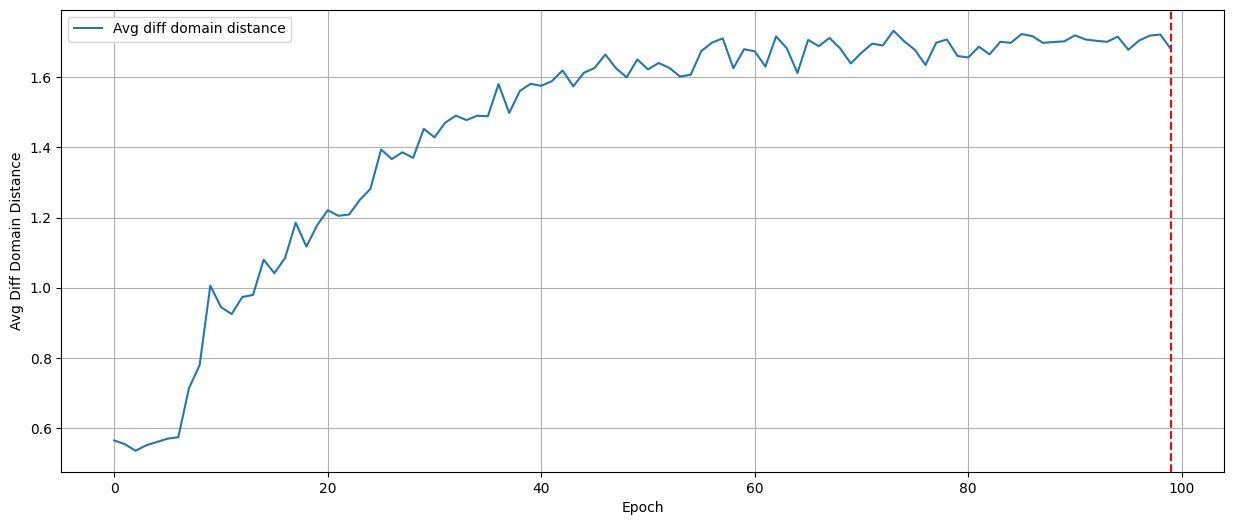

In [11]:
# Train domain classifier on Dp (CWRU)

with open('data/cwru_256_3ch_5cl.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

with open('data/cwru_256_3ch_5cl_fs.pkl', 'rb') as f:
    fs = pickle.load(f)

x = x[fs == 0]
y = y[fs == 0]
k = k[fs == 0]
x = x[k >= 4]
y = y[k >= 4]
k = k[k >= 4] - 4
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchSiameseNet(num_classes=5, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = contrastive_loss

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, initial_lr, epochs=100, name='siamese_net_cwru_te')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Avg same domain distance: {avg_same_domain_distance_test[best_epoch]:.4f} - Avg diff domain distance: {avg_diff_domain_distance_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the average same domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_same_domain_distance_test, label='Avg same domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Same Domain Distance')
plt.legend()
plt.grid()
plt.show()

# Plot the average different domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_diff_domain_distance_test, label='Avg diff domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Diff Domain Distance')
plt.legend()
plt.grid()
plt.show()